# Projet 7 :  Implémentez un modèle de scoring: Complément à la modélisation (Réduction de nombre de variable)

In [169]:
#Time
from datetime import timedelta, datetime, tzinfo, timezone

#graph
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import pyplot, transforms

#preprocessing & score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, make_scorer
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score
#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

#sampling
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import fbeta_score
import IPython.display
import warnings
warnings.filterwarnings('ignore')
sns.set()

In [2]:
file_path = '/Users/admin/Desktop/formation_data_Scientist/projet7/Donnees/' 

In [88]:
data_selected_train = pd.read_csv(file_path + 'X_train_selected')
data_train = pd.read_csv(file_path + 'X_train_final')
data_test = pd.read_csv(file_path + 'X_test_final')

In [27]:
data_selected_train

,Unnamed: 0,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,NAME_CONTRACT_TYPE_M,NAME_CONTRACT_TYPE_Pensioner,NAME_CONTRACT_TYPE_Working,NAME_CONTRACT_TYPE_Higher education,NAME_CONTRACT_TYPE_Secondary / secondary special,NAME_CONTRACT_TYPE_Laborers,NAME_CONTRACT_TYPE_XNA,NAME_CONTRACT_TYPE_block of flats,NAME_CONTRACT_TYPE_No,TARGET
0,0,-1.733423,0.142129,-0.478095,-0.166143,-0.507236,-0.149452,1.506880,-0.456215,0.379837,...,1.388176,-0.468573,0.967876,-0.567262,0.638808,2.138285,-0.468635,1.021382,0.963763,1.0
1,1,-1.733413,0.426792,1.725450,0.592683,1.600873,-1.252750,-0.166821,-0.460115,1.078697,...,-0.720370,-0.468573,-1.033190,1.762853,-1.565416,-0.467664,-0.468635,1.021382,0.963763,0.0
2,2,-1.733403,-0.427196,-1.152888,-1.404669,-1.092145,-0.783451,-0.689509,-0.453299,0.206116,...,1.388176,-0.468573,0.967876,-0.567262,0.638808,2.138285,-0.468635,-0.979065,-1.037599,0.0
3,3,-1.733384,-0.142533,-0.711430,0.177874,-0.653463,-0.928991,-0.680114,-0.473217,-1.375829,...,-0.720370,-0.468573,0.967876,-0.567262,0.638808,2.138285,-0.468635,-0.979065,-1.037599,0.0
4,4,-1.733374,-0.199466,-0.213734,-0.361749,-0.068554,0.563570,-0.892535,-0.473210,0.191639,...,1.388176,-0.468573,0.967876,-0.567262,0.638808,-0.467664,-0.468635,-0.979065,-1.037599,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,307506,1.732372,-0.047646,-0.855489,0.031015,-0.848433,0.845396,1.537586,-0.453377,-0.984955,...,1.388176,-0.468573,0.967876,-0.567262,0.638808,-0.467664,-0.468635,1.021382,0.963763,0.0
307507,307507,1.732381,-0.408219,-0.818594,-1.042333,-0.848433,0.310593,-1.085707,2.133617,0.169782,...,-0.720370,2.134139,-1.033190,-0.567262,0.638808,-0.467664,2.133857,1.021382,0.963763,0.0
307508,307508,1.732391,-0.066623,0.195379,0.198056,0.126415,-1.147120,0.245417,-0.507774,-0.497002,...,-0.720370,-0.468573,0.967876,1.762853,-1.565416,-0.467664,-0.468635,1.021382,0.963763,0.0
307509,307509,1.732401,0.009287,-0.568757,-0.476318,-0.592535,-1.124635,0.934008,-0.485583,0.688107,...,-0.720370,-0.468573,-1.033190,-0.567262,0.638808,2.138285,-0.468635,1.021382,0.963763,1.0


In [43]:
def preprocessing(df, test_size):
    X = df.copy().drop(['TARGET'], axis = 1)
    y = df['TARGET']
    categorical_columns = X.select_dtypes(['category','object']).columns
    numerical_columns = X.columns
    ss = StandardScaler()
    X[numerical_columns] = ss.fit_transform(X[numerical_columns])
   # X['SK_ID_CURR'] = df['SK_ID_CURR']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = test_size, random_state=42)
    return X, X_train, X_valid, y_train, y_valid

In [144]:
def preprocessing_2(df):
    X = df
    categorical_columns = X.select_dtypes(['category','object']).columns
    numerical_columns = X.columns
    ss = StandardScaler()
    X[numerical_columns] = ss.fit_transform(X[numerical_columns])
   # X['SK_ID_CURR'] = df['SK_ID_CURR']
    return X

In [18]:
file1 = open('/Users/admin/Desktop/applications/best_model_B_S.pkl', 'rb')
model = pickle.load(file1)
file1.close()

# Affichage des varibles importantes

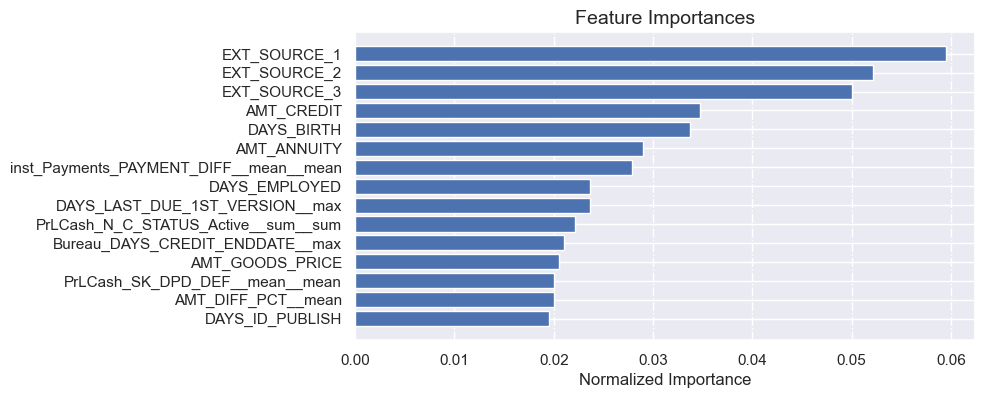

In [19]:
def feature_importance(model, X):
    feature_importances = model.feature_importances_

    feature_names = X.columns

    # Create a dictionary of feature names and importances
    feature_importances_dict = dict(zip(feature_names, feature_importances))
    sum_of_importance = best_model_B_S.feature_importances_.sum()
    # Sort the feature importances by importance
    sorted_feature_importances = sorted(feature_importances_dict.items(), key=lambda x: x[1], reverse=True)
    list_features = []
    importances = []
    # Print the feature importances
    for feature, importance in sorted_feature_importances:
    #print(f'{feature}: {importance/sum_of_importance:.4f}')
        importances.append(importance/sum_of_importance)
        list_features.append(feature)    

    df_importance_feature  = pd.DataFrame(importances, list_features)
    df_importance_feature = df_importance_feature.reset_index()
    df_importance_feature.columns = ['feature', 'imprtance']
    df_importance_feature = df_importance_feature.sort_values(by='imprtance',ascending=False)


    plt.figure(figsize = (8, 4))
    ax = plt.subplot()
    ax.invert_yaxis()
    ax.grid(visible = True, axis = 'x', linestyle = '-.')
    ax.barh(df_importance_feature['feature'].head(15),
        df_importance_feature['imprtance'].head(15), 
        align = 'center')
    
    ax.set_xlabel('Normalized Importance', fontsize = 12)
    ax.set_title('Feature Importances', fontsize = 14)
    #plt.show()
    return plt.show()
best_model_B_S = model
feature_importance(best_model_B_S, X_train)


## Sélection des variables 

In [106]:
def reduction_dimension(df, var_to_keep):
    col_df = list(df.columns)
    #col_sel_train = list(data_selected_train.columns)
    col_to_drop = [i for i in col_df if i not in var_to_keep]
    df = df.drop(col_to_drop, axis = 1)
    return df 

In [107]:
var_to_keep_test = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT', 'DAYS_BIRTH', 'AMT_ANNUITY']

In [118]:
var_to_keep_train = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
               'AMT_CREDIT', 'DAYS_BIRTH', 'AMT_ANNUITY', 'TARGET']
var_to_keep_test = var_to_keep_train.copy()
var_to_keep_test.remove('TARGET')

In [198]:
data_train_1 = reduction_dimension(data_selected_train, var_to_keep_train)
data_test_1  = reduction_dimension(data_test, var_to_keep_test)

In [163]:
X, X_train, X_valid, y_train, y_valid = preprocessing(data_train_1, 0.2)
X_test_2 = preprocessing_2(data_test_1)

In [199]:
data_test_1

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,568800.0,20560.5,-19241.0,0.752614,0.789654,0.159520
1,222768.0,17370.0,-18064.0,0.564990,0.291656,0.432962
2,663264.0,69777.0,-20038.0,0.506771,0.699787,0.610991
3,1575000.0,49018.5,-13976.0,0.525734,0.509677,0.612704
4,625500.0,32067.0,-13040.0,0.202145,0.425687,0.519097
...,...,...,...,...,...,...
48739,412560.0,17473.5,-19970.0,0.506771,0.648575,0.643026
48740,622413.0,31909.5,-11186.0,0.506771,0.684596,0.519097
48741,315000.0,33205.5,-15922.0,0.733503,0.632770,0.283712
48742,450000.0,25128.0,-13968.0,0.373090,0.445701,0.595456


In [73]:
X_train_test = X_train.copy()
X_train_test.columns = [i for i in range(X_train.shape[1])]

In [74]:
param_grid = {
        'max_depth': (6, 10),
        'num_leaves':(15, 20),
        #'min_data_in_leaf': (230, 250),
        #'min_child_samples': (20, 30), 
        #'feature_fraction': (0.5, 0.8),
    }

In [175]:
X

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,-0.478095,-0.166143,1.506880,-3.021877,-1.317940,-2.153651
1,1.725450,0.592683,-0.166821,-1.384737,0.564482,0.112063
2,-1.152888,-1.404669,-0.689509,0.012103,0.216948,1.223975
3,-0.711430,0.177874,-0.680114,0.012103,0.712205,0.112063
4,-0.213734,-0.361749,-0.892535,0.012103,-1.004691,0.112063
...,...,...,...,...,...,...
307506,-0.855489,0.031015,1.537586,-2.573313,0.875619,0.112063
307507,-0.818594,-1.042333,-1.085707,0.012103,-2.087872,0.112063
307508,0.195379,0.198056,0.245417,1.719527,0.111167,-1.698773
307509,-0.568757,-0.476318,0.934008,0.012103,-0.001784,0.831707


## Etude du leakage (corrélations des features avec la target).

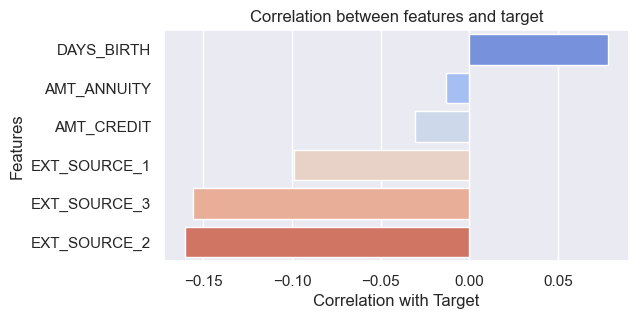

In [200]:
def corr_with_target(df, target_col, size_x, size_y):
    corr_matrix = df.select_dtypes(include=['int', 'float']).corrwith(df[target_col]).sort_values(ascending=False)
    corr_matrix.drop(target_col, inplace=True)
    plt.figure(figsize=(size_x, size_y))
    ax = sns.barplot(x=corr_matrix.values, y=corr_matrix.index, palette="coolwarm")
    ax.set_xlabel("Correlation with Target")
    ax.set_ylabel("Features")
    ax.set_title("Correlation between features and target")
    plt.show()

X_with_target = X.copy()
X_with_target['TARGET'] = data_selected_train['TARGET']
corr_with_target(X_with_target, 'TARGET', 6, 3)

In [184]:
X_with_target

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,-0.478095,-0.166143,1.506880,-3.021877,-1.317940,-2.153651,1.0
1,1.725450,0.592683,-0.166821,-1.384737,0.564482,0.112063,0.0
2,-1.152888,-1.404669,-0.689509,0.012103,0.216948,1.223975,0.0
3,-0.711430,0.177874,-0.680114,0.012103,0.712205,0.112063,0.0
4,-0.213734,-0.361749,-0.892535,0.012103,-1.004691,0.112063,0.0
...,...,...,...,...,...,...,...
307506,-0.855489,0.031015,1.537586,-2.573313,0.875619,0.112063,0.0
307507,-0.818594,-1.042333,-1.085707,0.012103,-2.087872,0.112063,0.0
307508,0.195379,0.198056,0.245417,1.719527,0.111167,-1.698773,0.0
307509,-0.568757,-0.476318,0.934008,0.012103,-0.001784,0.831707,1.0


In [75]:
def bank_score(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true,y_pred)
    
    tn = mat_conf[0, 0]
    fn = mat_conf[1, 0]
    fp = mat_conf[0, 1]
    tp = mat_conf[1, 1]
    
    
    Gain_tot = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    G_max = (fp + tn)*tn_value + (fn + tp)*tp_value
    G_min = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    G_normalized = (Gain_tot - G_min)/(G_max - G_min)
    
    return G_normalized  

## optimisation des parametres du modèle

  0%|                                                     | 0/2 [00:00<?, ?it/s]


les meilleur paramètres sont: {'max_depth': 6, 'num_leaves': 15}


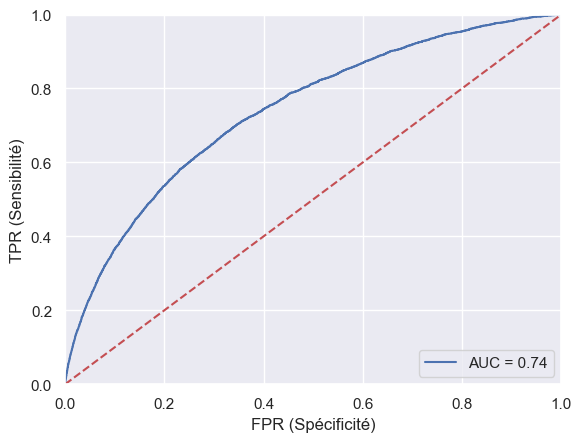

Temps d'exécution: -0.001269015001525986


In [77]:
def model_optim(model, param_grid, X, y):
    import timeit
    start_time = timeit.timeit()
    with tqdm(total=len(param_grid)) as pbar:
        def grid_search_callback(*args, **kwargs):
            pbar.update()
# votre code ic
    cv = 3
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring=bank_score,
                               cv=cv)
    grid_search.fit(X, y, callbacks=[grid_search_callback])
    best_param = grid_search.best_params_
    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    model.set_params(**best_param)
    y_pred_grd = best_model.predict_proba(X_valid)[:, 1]    
    end_time = timeit.timeit()
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_grd)
    print('les meilleur paramètres sont:', best_param)
# Calcul de l'AUC
    roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.ylabel('TPR (Sensibilité)')
    plt.xlabel('FPR (Spécificité)')
    plt.show()
    print("Temps d'exécution:", end_time - start_time)
    return best_model, best_param, best_score, y_pred_grd
best_model_B_S, best_param_B_S, best_score_B_S, y_pred_grd_B_S = model_optim(LGBMClassifier(), param_grid,  X_train_test, y_train)

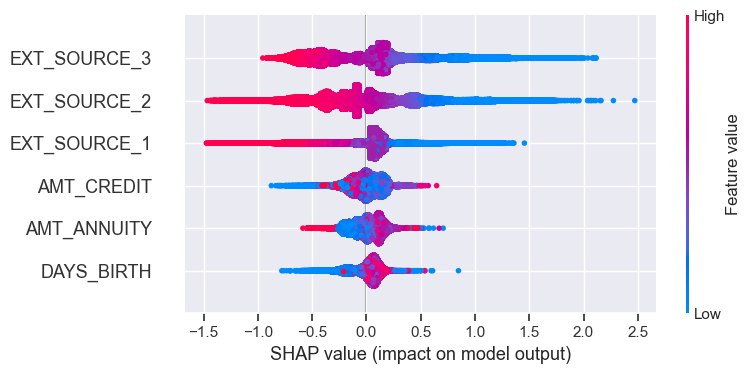

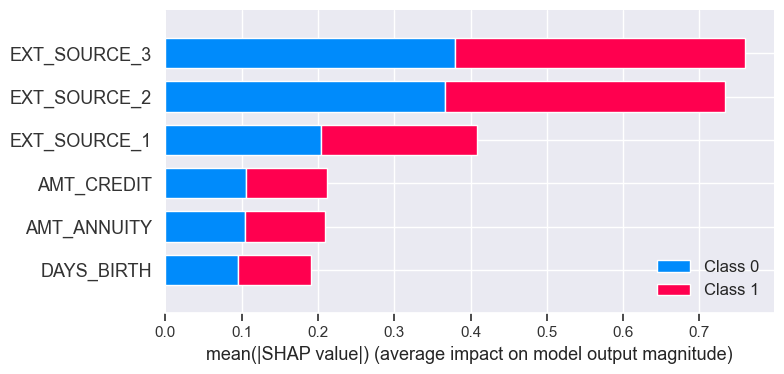

In [140]:
import shap
def feature_importance_graphic(model, X):
    X_importance = X
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_importance)
    shap.summary_plot(shap_values[1], X_importance)
    shap.summary_plot(shap_values, X_importance, plot_type='bar')
    #shap.force_plot(explainer.expected_value[1], shap_values[1], X)
    return 
feature_importance_graphic(best_model_B_S, pd.get_dummies(X_train))

In [124]:
#best_model_B_S

In [125]:
def optimize_threshold_bank_score(model, X, y, fn_value=-10, fp_value=1, tp_value=0, tn_value=0):
    y_pred = model.predict_proba(X)[:,1]
    thresholds = np.arange(0, 1.05, 0.005)
    scores = []
    for threshold in thresholds:
        y_pred_bin = (y_pred > threshold).astype(int)
        score = bank_score(y, y_pred_bin, fn_value, fp_value, tp_value, tn_value)
        scores.append(score)
    best_threshold = thresholds[np.argmax(scores)]
    plt.plot(thresholds, scores)
    plt.xlabel('Thresholds')
    plt.ylabel('bank_score')
    plt.show()
    return best_threshold

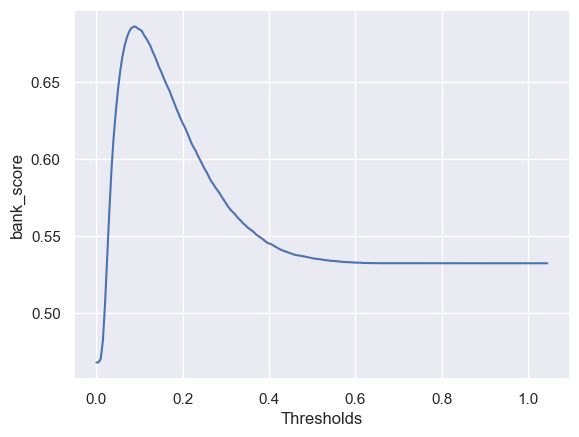

0.09

In [126]:
optimize_threshold_bank_score(best_model_B_S, X_train, y_train, fn_value=10, fp_value=1, tp_value=0, tn_value=0)

## Prédiction sur les données test

In [165]:
y_proba_test = best_model_B_S.predict_proba(X_test_2)[:, 1]
y_pred_test = (y_proba_test > 0.09)
y_pred_test = np.array(y_pred_test > 0) * 1
X_test_2["TARGET"] = y_pred_test

In [166]:
X_test_2["TARGET"].value_counts()

0    36812
1    11932
Name: TARGET, dtype: int64

## Enregistrement du modèle et des datasets train/test

In [81]:
import pickle
final_model = best_model_B_S
# Save the model to a file
with open('final_model1.pkl', 'wb') as f:
    pickle.dump(best_model_B_S, f)

In [63]:
import os
print(os.getcwd())

/Users/admin/Desktop/Implémentez_un modèle_de_scoring_Mohamed_Assali


In [167]:
X_test_2.to_csv(file_path + 'X_test_2')
X_train.to_csv(file_path + 'X_train_2')

In [195]:
X_test_2.describe()

,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
count,4.874400e+04,4.874400e+04,4.874400e+04,4.874400e+04,4.874400e+04,4.874400e+04,48744.000000
mean,1.429004e-17,1.236212e-16,1.469729e-16,5.852692e-16,-3.957834e-16,-7.780717e-16,0.244789
std,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,1.000010e+00,0.429966
min,-1.291049e+00,-1.694288e+00,-2.109852e+00,-3.139732e+00,-2.857848e+00,-2.924565e+00,0.000000
25%,-7.008899e-01,-7.151730e-01,-8.250195e-01,-2.450410e-01,-6.065566e-01,-6.036141e-01,0.000000
50%,-1.826537e-01,-2.014468e-01,6.544014e-02,2.073315e-02,2.247032e-01,9.079439e-02,0.000000
75%,4.331212e-01,4.974794e-01,8.257521e-01,3.059567e-01,7.748559e-01,7.043521e-01,0.000000
max,4.731230e+00,9.439631e+00,2.018117e+00,2.790779e+00,1.859031e+00,2.204069e+00,1.000000
